# Распределение товаров по категориям

## Инициализация

In [1]:
import os
import sys

from django.utils import timezone

sys.path.append('/home/ubuntu/anodos.ru/anodos/')
os.environ['DJANGO_SETTINGS_MODULE'] = 'anodos.settings'

from django.core.wsgi import get_wsgi_application
application = get_wsgi_application()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import catalog.runner
from catalog.models import *

## Загружаю данные о продуктах

### Описание полей:
- **id** - идентификатор в базе;
- **vendor** - идентификатор производителя;
- **category** - категория продукта (идентификатор);
- **unit** - единица измерения;
- **double** - если продукт является дублем имеющегося - ссылка на исходный;
- **price_type** - тип цены (как правило - розничная);
- **currency** - идентификатор валюты цены (на данный момент только рубль);
- **name** - имя продукта;
- **article** - артикул продукта (уникален для производителя);
- **alias** - производитель, артикул и имя продукта, приведённые в вид, оптимизированный для индексации поиска;
- **description** - описание продукта (реализация в будущем);
- **edited** - редактировался ли продукт вручную;
- **tested** - объект проверен вручную, все данные о нём верны;
- **for_export** - экспортировать ли информацию во внешние системы, например, в Яндекс.Маркет (реализация в будущем);
- **on_stock** - количество, доступное на складах;
- **on_transit** - количество, доступное в транзитах;
- **on_factory** - количество, доступное на заказ;
- **price** - цена;
- **fixed** - фиксирована ли цена (True для некоторых программных продуктов или для акционного продукта);
- **state** - статус объекта (если False - объект не используется ни в каких обработках);
- **created** - дата и время создания объёкта в базе;
- **modified** - дата последнего изменения объекта.

In [3]:
# Загружаем продукты одного производителя
vendor_alias = 'lenovo'

products = Product.objects.get_df(vendor__alias = vendor_alias, double = None)
print(products.info())
products.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 22 columns):
id             3113 non-null int64
vendor         3113 non-null int64
category       0 non-null object
unit           3113 non-null int64
double         0 non-null object
price_type     3113 non-null int64
currency       3113 non-null int64
name           3113 non-null object
article        3113 non-null object
alias          3113 non-null object
description    3089 non-null object
edited         3113 non-null bool
tested         3113 non-null bool
for_export     3113 non-null bool
on_stock       3093 non-null float64
on_transit     3063 non-null float64
on_factory     3113 non-null float64
price          2624 non-null object
fixed          3113 non-null bool
state          3113 non-null bool
created        3113 non-null datetime64[ns, UTC]
modified       3113 non-null datetime64[ns, UTC]
dtypes: bool(5), datetime64[ns, UTC](2), float64(3), int64(5), object(7)
memory usage: 428.7+

,id,vendor,category,unit,double,price_type,currency,name,article,alias,...,tested,for_export,on_stock,on_transit,on_factory,price,fixed,state,created,modified
0,198746,635,None,1,None,2,1,240GB SATA 2.5in MLC G3HS Enterprise Value SSD,00AJ400,lenovo 00aj400 240gb sata 2 5in mlc g3hs enter...,...,False,False,14.0,0.0,0.0,37411.73,False,True,2017-08-17 01:51:52.720753+00:00,2017-08-17 01:51:52.720763+00:00
1,211300,635,None,1,None,2,1,"2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord",00NA029,lenovo 00na029 2 8m 10a 230v c13 to cee7-vii e...,...,False,False,1.0,0.0,0.0,None,False,True,2017-08-17 01:59:50.255641+00:00,2017-08-17 01:59:50.255652+00:00
2,205567,635,None,1,None,2,1,"32GB TruDDR4 Memory 4Rx4, 1.2V PC417000 CL15 2...",46W0800,lenovo 46w0800 32gb truddr4 memory 4rx4 1 2v p...,...,False,False,48.0,0.0,0.0,34720.48,False,True,2017-08-17 01:56:10.741451+00:00,2017-08-17 01:56:10.741464+00:00
3,205521,635,None,1,None,2,1,"4TB 7,200 rpm 6Gb SAS NL 3.5in HDD",00Y2475,lenovo 00y2475 4tb 7 200 rpm 6gb sas nl 3 5in ...,...,False,False,0.0,0.0,0.0,None,False,True,2017-08-17 01:56:08.100973+00:00,2017-08-17 01:56:08.100982+00:00
4,202886,635,None,1,None,2,1,"900GB 10,000 rpm 6Gb SAS 2.5in HDD",00W1236,lenovo 00w1236 900gb 10 000 rpm 6gb sas 2 5in ...,...,False,False,0.0,0.0,0.0,None,False,True,2017-08-17 01:54:28.054604+00:00,2017-08-17 01:54:28.054614+00:00


## Загружаем все возможные наименования продуктов

У разных поставщиков один и тот-же продукт может называться по разному.

### Описание полей:
- **id** - идентификатор в базе;
- **product** - продукт, которому соответствует имя;
- **name** - имя;
- **state** - статус;
- **created** - дата и время создания;
- **modified** - дата и время последнего редактирования.

In [4]:
input_names = ProductInputName.objects.get_df(product__vendor__alias = vendor_alias,
                                              product__double = None)
print(input_names.info())
input_names.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4907 entries, 0 to 4906
Data columns (total 6 columns):
id          4907 non-null object
product     4907 non-null int64
name        4907 non-null object
state       4907 non-null bool
created     4907 non-null datetime64[ns, UTC]
modified    4907 non-null datetime64[ns, UTC]
dtypes: bool(1), datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 196.5+ KB
None


,id,product,name,state,created,modified
0,169ff1ed-5ec9-4614-bc91-c8ceca3fdf0b,11367,01DC659,True,2017-08-17 01:56:17.343533+00:00,2017-08-17 01:56:17.343542+00:00
1,8c22424c-977c-4d69-8f15-3e54c8ef01e6,197766,0.6m SAS Cable mSAS HD to mSAS HD,True,2017-08-17 01:56:35.107913+00:00,2017-08-17 01:56:35.107922+00:00
2,353f57ec-64a5-422b-ba58-a0ba51cb1b22,166697,"1.2 TB 10,000 rpm 6 Gb SAS 2.5 Inch HDD",True,2017-08-17 01:57:24.292594+00:00,2017-08-17 01:57:24.292603+00:00
3,4d6c6642-d4cf-4fda-b65b-4e5a6c893778,9440,1.2TB 10K 12Gbps SAS 2.5in G3HS HDD,True,2017-08-17 01:59:29.399773+00:00,2017-08-17 01:59:29.399782+00:00
4,86dac419-9482-45b7-8b5a-00d9d8eee7bc,11344,1.5m SAS Cable mSAS HD to mSAS HD,True,2017-08-17 01:56:34.704781+00:00,2017-08-17 01:56:34.704789+00:00


## Загружаем все возможные наименования категорий продуктов

Категории у разных поставщиков называются по разному.

### Описание полей:
- **id** - идентификатор в базе;
- **product** - продукт, которому соответствует имя категории;
- **category** - имя категори;
- **state** - статус;
- **created** - дата и время создания;
- **modified** - дата и время последнего редактирования.

In [5]:
input_categories = ProductInputCategory.objects.get_df(product__vendor__alias = vendor_alias,
                                                       product__double = None)
print(input_categories.info())
input_categories.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4603 entries, 0 to 4602
Data columns (total 6 columns):
id          4603 non-null object
product     4603 non-null int64
category    4595 non-null object
state       4603 non-null bool
created     4603 non-null datetime64[ns, UTC]
modified    4603 non-null datetime64[ns, UTC]
dtypes: bool(1), datetime64[ns, UTC](2), int64(1), object(2)
memory usage: 184.4+ KB
None


,id,product,category,state,created,modified
0,27f0d6a9-4519-4b2e-bc3a-a6ac58d7c604,232396,,True,2017-08-17 03:26:16.491328+00:00,2017-08-17 03:26:16.491336+00:00
1,baddfeed-80f1-405d-ac0a-f08a5f7d6562,232388,,True,2017-08-17 03:26:13.229843+00:00,2017-08-17 03:26:13.229851+00:00
2,080722aa-a028-4fad-a198-3288af149786,232387,,True,2017-08-17 03:26:13.192675+00:00,2017-08-17 03:26:13.192683+00:00
3,d3aa9f7b-3473-4b40-b953-32b5eb7c5875,232386,,True,2017-08-17 03:26:13.141901+00:00,2017-08-17 03:26:13.141909+00:00
4,4069337f-9d9c-4f43-945f-27490580a35a,232384,,True,2017-08-17 03:26:13.061876+00:00,2017-08-17 03:26:13.061884+00:00


## Переносим имена продуктов и категорий в DF продуктов

In [6]:
def get_input_names(product):
    filtered_names = input_names[input_names['product'] == product]
    if len(filtered_names):
        names = []
        for i, row in filtered_names.iterrows():
            names.append(row['name'])
        names = ' '.join(names)
    else:
        names = ''
    return names

products['input_names'] = products['id'].map(get_input_names)
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 23 columns):
id             3113 non-null int64
vendor         3113 non-null int64
category       0 non-null object
unit           3113 non-null int64
double         0 non-null object
price_type     3113 non-null int64
currency       3113 non-null int64
name           3113 non-null object
article        3113 non-null object
alias          3113 non-null object
description    3089 non-null object
edited         3113 non-null bool
tested         3113 non-null bool
for_export     3113 non-null bool
on_stock       3093 non-null float64
on_transit     3063 non-null float64
on_factory     3113 non-null float64
price          2624 non-null object
fixed          3113 non-null bool
state          3113 non-null bool
created        3113 non-null datetime64[ns, UTC]
modified       3113 non-null datetime64[ns, UTC]
input_names    3113 non-null object
dtypes: bool(5), datetime64[ns, UTC](2), float64(3), int6

In [7]:
def get_input_categories(product):
    filtered_categories = input_categories[input_categories['product'] == product]
    if len(filtered_categories):
        categories = []
        for i, row in filtered_categories.iterrows():
            if row['category']:
                categories.append(row['category'])
        categories = ' '.join(categories)
    else:
        categories = ''
    return categories

products['input_categories'] = products['id'].map(get_input_categories)
print(products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113 entries, 0 to 3112
Data columns (total 24 columns):
id                  3113 non-null int64
vendor              3113 non-null int64
category            0 non-null object
unit                3113 non-null int64
double              0 non-null object
price_type          3113 non-null int64
currency            3113 non-null int64
name                3113 non-null object
article             3113 non-null object
alias               3113 non-null object
description         3089 non-null object
edited              3113 non-null bool
tested              3113 non-null bool
for_export          3113 non-null bool
on_stock            3093 non-null float64
on_transit          3063 non-null float64
on_factory          3113 non-null float64
price               2624 non-null object
fixed               3113 non-null bool
state               3113 non-null bool
created             3113 non-null datetime64[ns, UTC]
modified            3113 non-null dat

In [8]:
products.head()

,id,vendor,category,unit,double,price_type,currency,name,article,alias,...,on_stock,on_transit,on_factory,price,fixed,state,created,modified,input_names,input_categories
0,198746,635,None,1,None,2,1,240GB SATA 2.5in MLC G3HS Enterprise Value SSD,00AJ400,lenovo 00aj400 240gb sata 2 5in mlc g3hs enter...,...,14.0,0.0,0.0,37411.73,False,True,2017-08-17 01:51:52.720753+00:00,2017-08-17 01:51:52.720763+00:00,240GB SATA 2.5in MLC G3HS Enterprise Value SSD,Серверы | Опции для серверов Brandname | Жёстк...
1,211300,635,None,1,None,2,1,"2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord",00NA029,lenovo 00na029 2 8m 10a 230v c13 to cee7-vii e...,...,1.0,0.0,0.0,None,False,True,2017-08-17 01:59:50.255641+00:00,2017-08-17 01:59:50.255652+00:00,"2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord",Системы хранения данных | Внешние опции для си...
2,205567,635,None,1,None,2,1,"32GB TruDDR4 Memory 4Rx4, 1.2V PC417000 CL15 2...",46W0800,lenovo 46w0800 32gb truddr4 memory 4rx4 1 2v p...,...,48.0,0.0,0.0,34720.48,False,True,2017-08-17 01:56:10.741451+00:00,2017-08-17 01:56:10.741464+00:00,"32GB TruDDR4 Memory 4Rx4, 1.2V PC417000 CL15 2...",Серверы | Опции для серверов Brandname | Опера...
3,205521,635,None,1,None,2,1,"4TB 7,200 rpm 6Gb SAS NL 3.5in HDD",00Y2475,lenovo 00y2475 4tb 7 200 rpm 6gb sas nl 3 5in ...,...,0.0,0.0,0.0,None,False,True,2017-08-17 01:56:08.100973+00:00,2017-08-17 01:56:08.100982+00:00,"4TB 7,200 rpm 6Gb SAS NL 3.5in HDD",Серверы | Опции для серверов Brandname | Жёстк...
4,202886,635,None,1,None,2,1,"900GB 10,000 rpm 6Gb SAS 2.5in HDD",00W1236,lenovo 00w1236 900gb 10 000 rpm 6gb sas 2 5in ...,...,0.0,0.0,0.0,None,False,True,2017-08-17 01:54:28.054604+00:00,2017-08-17 01:54:28.054614+00:00,"900GB 10,000 rpm 6Gb SAS 2.5in HDD",Системы хранения данных | Внутренние опции для...


## Извлечение признаков

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# Вычисляем признаки из текущих имён
names_td_idf = TfidfVectorizer()
X_names = names_td_idf.fit_transform(products['name'])

print('Размер исходной мартицы:', products.shape)
print('Размер матрицы признаков:', X_names.shape)

Размер исходной мартицы: (3113, 24)
Размер матрицы признаков: (3113, 3754)


In [11]:
# Вычисляем признаки из исходных имён
input_names_td_idf = TfidfVectorizer()
X_input_names = input_names_td_idf.fit_transform(products['input_names'])

print('Размер исходной мартицы:', products.shape)
print('Размер матрицы признаков:', X_input_names.shape)

Размер исходной мартицы: (3113, 24)
Размер матрицы признаков: (3113, 4610)


In [12]:
# Вычисляем признаки из исходных категорий
input_categories_td_idf = TfidfVectorizer()
X_input_categories = input_categories_td_idf.fit_transform(products['input_categories'])

print('Размер исходной мартицы:', products.shape)
print('Размер матрицы признаков:', X_input_categories.shape)

Размер исходной мартицы: (3113, 24)
Размер матрицы признаков: (3113, 231)


In [13]:
from scipy.sparse import coo_matrix, hstack

# Объединяем мартицы признаков
X = hstack([X_names, X_input_names, X_input_categories]).toarray()
print(X.shape)

(3113, 8595)


## Кластеризация продуктов

Необходимо кластеризовать продукты, чтобы кластеры "раскидать" по категориям.

Перевести и разобраться в описании методов [sklearn.cluster](http://scikit-learn.org/stable/modules/clustering.html#clustering)

In [27]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Выбрать оптимальные параметра eps и min_samples
epses = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
labels = []
counts_of_clasters = []
counts_of_not_clasters = []

for eps in epses:
    db = DBSCAN(eps=eps, min_samples=2, metric='cosine')
    db.fit(X)
    labels.append(db.labels_)
    
    uniques_labels = set()
    count = 0
    for label in db.labels_:
        uniques_labels.add(label)
        if label == -1:
            count += 1

    counts_of_clasters.append(len(uniques_labels))
    counts_of_not_clasters.append(count)

[271, 342, 315, 225, 143, 54, 21, 4, 1]


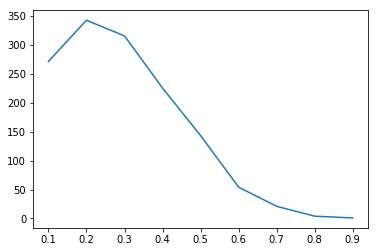

In [28]:
print(counts_of_clasters)
plt.plot(epses, counts_of_clasters)

[1914, 1239, 734, 410, 206, 79, 19, 3, 0]


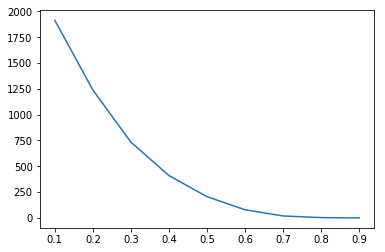

In [29]:
print(counts_of_not_clasters)
plt.plot(epses, counts_of_not_clasters)

In [22]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.35, min_samples=2, metric='cosine')
db.fit(X)
labels.append(db.labels_)
    
uniques_labels = set()
count = 0
for label in db.labels_:
    uniques_labels.add(label)
    if label == -1:
        count += 1

print('Количество кластеров:', len(uniques_labels))
print('Элементов вне кластеров:', count)

Количество кластеров: 270
Элементов вне кластеров: 565


In [24]:
products['cluster'] = db.labels_
products.head()

,id,vendor,category,unit,double,price_type,currency,name,article,alias,...,on_transit,on_factory,price,fixed,state,created,modified,input_names,input_categories,cluster
0,198746,635,None,1,None,2,1,240GB SATA 2.5in MLC G3HS Enterprise Value SSD,00AJ400,lenovo 00aj400 240gb sata 2 5in mlc g3hs enter...,...,0.0,0.0,37411.73,False,True,2017-08-17 01:51:52.720753+00:00,2017-08-17 01:51:52.720763+00:00,240GB SATA 2.5in MLC G3HS Enterprise Value SSD,Серверы | Опции для серверов Brandname | Жёстк...,-1
1,211300,635,None,1,None,2,1,"2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord",00NA029,lenovo 00na029 2 8m 10a 230v c13 to cee7-vii e...,...,0.0,0.0,None,False,True,2017-08-17 01:59:50.255641+00:00,2017-08-17 01:59:50.255652+00:00,"2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord",Системы хранения данных | Внешние опции для си...,0
2,205567,635,None,1,None,2,1,"32GB TruDDR4 Memory 4Rx4, 1.2V PC417000 CL15 2...",46W0800,lenovo 46w0800 32gb truddr4 memory 4rx4 1 2v p...,...,0.0,0.0,34720.48,False,True,2017-08-17 01:56:10.741451+00:00,2017-08-17 01:56:10.741464+00:00,"32GB TruDDR4 Memory 4Rx4, 1.2V PC417000 CL15 2...",Серверы | Опции для серверов Brandname | Опера...,-1
3,205521,635,None,1,None,2,1,"4TB 7,200 rpm 6Gb SAS NL 3.5in HDD",00Y2475,lenovo 00y2475 4tb 7 200 rpm 6gb sas nl 3 5in ...,...,0.0,0.0,None,False,True,2017-08-17 01:56:08.100973+00:00,2017-08-17 01:56:08.100982+00:00,"4TB 7,200 rpm 6Gb SAS NL 3.5in HDD",Серверы | Опции для серверов Brandname | Жёстк...,-1
4,202886,635,None,1,None,2,1,"900GB 10,000 rpm 6Gb SAS 2.5in HDD",00W1236,lenovo 00w1236 900gb 10 000 rpm 6gb sas 2 5in ...,...,0.0,0.0,None,False,True,2017-08-17 01:54:28.054604+00:00,2017-08-17 01:54:28.054614+00:00,"900GB 10,000 rpm 6Gb SAS 2.5in HDD",Системы хранения данных | Внутренние опции для...,-1


In [26]:
for cluster in uniques_labels:
    print(cluster, products[products.cluster == cluster].shape[0])
    for i, row in products[products.cluster == cluster].iterrows():
        print(row['name'], row['description'])
    print('')

0 3
2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord 
Lenovo TopSeller Line cord 2.8m, 10A/230V, C13 to CEE7-VII Europe 
Кабель 2.8m, 10A/230V, C13 to CEE7-VII Europe Line Cord 

1 5
Brocade 10Gb SFP+ SR Optical Transceiver 
Brocade 8 Gb SFP+ SW Optical Transceiver 
Lenovo Brocade 8Gb SFP+ Optical Transceiver 
Lenovo TopSeller BNT 10Gb SFP+ SR Optical Transceiver 
QLogic 10Gb SFP+ SR Optical Transceiver 

2 4
DisplayPort to DisplayPort Monitor Cable 
Lenovo Mini-DisplayPort to DisplayPort Cable 2м 
Lenovo Mini-DisplayPort to DVI Cable 
Lenovo Mini-DisplayPort to VGA Monitor Cable 

3 2
IBM Media Product Reference Guide 
IBM Media Product Reference Guide new release 

4 200
IdeaCentre AIO 520-22IKL Monitor stand 21.5"1920x1080/Intel Pentium G4560T2.9Ghz/4096Mb/1000Gb/noDVD/Ext:AMD Radeon 5302048Mb/BT/WiFi/war 1y/5.65kg/black/W10 + Клавиатура, мышь 
IdeaCentre AIO 520-22IKL Monitor stand 21.5"1920x1080/Intel Pentium G4560T2.9Ghz/4096Mb/1000Gb/noDVD/Ext:AMD Radeon 5302048Mb/BT/WiFi/war 1y

ThinkPad EDGE E570 15.6"FHD1920x1080, I5-72002,5GHz, 8GB DDR4, 1TB / 5400, Intel HD 620, FPR,BT,WiFi, DVD RW, Win 10 PRO, Black+Silver C-cover,4cell, 2,3 kg, 1y carry in E570, 15.6" (1920x1080), i5-7200U(2.5GHz), 8GB, 1TB, Intel HD, DVDRW, WiFi, BT, FPR, WebCam, 4cell, Win 10 Pro
ThinkPad EDGE E570 15.6"FHD1920x1080, I5-7200U 2,5GHz, 4GB DDR4, 180GB SSD, Intel HD 620, FPR,BT,WiFi, DVD RW, Win 10 PRO, Black+Silver C-cover,4cell, 2,3 kg, 1y carry in 
ThinkPad EDGE E570 15.6"HD1366x768, i3-6006U2,0GHz, 4GB DDR4, 500GB@7200,Intel HD 520,WWANnone, DVDRW,Camera, BT,WiFi, 4cell, DOS, Black+silver, 2,3Kg 1y.carry in E570, 15.6" (1366x768), i3-6006U(2.0GHz), 4GB, 500GB (7200rpm), Intel HD, DVDRW, WiFi, BT, FPR, WebCam, 4cell, DOS
ThinkPad EDGE E570 15.6"HD1366x768, I3_6006U 2,0 GHz, 4GB DDR4, 500GB / 7200, Intel HD 620, BT,WiFi, DVD, Win 10 PRO, Black+Silver2,3 kg, 1y carry in E570, 15.6" (1366x768), i3-6006U(2.0GHz), 4GB, 500GB (7200rpm), Intel HD, DVDRW, WiFi, BT, FPR, WebCam, 4cell, Win 10 P

Lenovo ThinkCentre Tiny M710q G4560T 4Gb 128GB_SSD Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse Win 10 Pro64 3Y on-site 
Lenovo ThinkCentre Tiny M710q G4560T 4Gb 500GB Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse DOS 3Y on-site 
Lenovo ThinkCentre Tiny M710q I3-7100T 4Gb 128GB_SSD Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse NO_OS 3Y on-site 
Lenovo ThinkCentre Tiny M710q I3-7100T 4Gb 128GB_SSD Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse Win 10 Pro 64 3Y on-site 
Lenovo ThinkCentreTiny M710q I3-7100T 4Gb 128GB_SSD Intel HD NoDVD INTEL8265+BT_2X2AC USB KB&Mouse Win 10 Pro 64 3Y on-site 
Lenovo ThinkCentre Tiny M710q I3-7100T 4Gb 500GB Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse No OS 3Y on-site 
Lenovo ThinkCentre Tiny M710q I3-7100T 4Gb 500GB Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse Win 10 Pro 64-RUS 3Y on-site 
Lenovo ThinkCentre Tiny M710q I3-7100T 8Gb 1TB Intel HD NoDVD INTEL_3165+BT_1X1AC USB KB&Mouse Win 10Pro 64 3Y on-site 
Lenovo ThinkCentre Tiny M710q I3

Кабель Lenovo 13 m LC-LC Fibre Cable 
Кабель Lenovo 5m Fiber Cable (LC) 
Кабель оптоволоконный 5m LC-LC Fiber Cable networking 
Оптический кабель 5m Fiber Cable LC 

118 2
Кабель Lenovo 01DC681 1m V3700 V2 Fiber LC 
Кабель Lenovo 01DC683 5m V3700 V2 Fiber LC 

119 2
Кабель Lenovo System x Enterprise 1U Management Arm (CMA) (00KA607) Крепеж System x Enterprise 1U Cable Management Arm (CMA)
Кабель Lenovo System x Enterprise 2U Management Arm (CMA) (00FK622) 

120 2
Код активации Brocade 300/6505 S/W, Enterprise Bundle TRK, FV, EF 
Код активации Brocade 6510 S/W, Enterprise Bundle TRK, FV, EF 

121 4
Код активации Brocade 300/6505 S/W, Extended Fabric 
Код активации Brocade 300/6505 S/W, Fabric Vision 
Код активации Brocade 6510 S/W, Extended Fabric 
Код активации Brocade 6510 S/W, Fabric Vision 

122 2
Код активации Brocade 300/6505 S/W, ISL Trunking 
Код активации Brocade 6510 S/W, ISL Trunking 

123 25
Компьютер планшетный Lenovo Lenovo Tab 2 A10-30  10.1'' WXGA(1280x800) IPS/Qualcomm 

ПК Lenovo ThinkCentre M600 TINY slim Cel N3010/2Gb/SSD16Gb/noOS/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M600 TINY slim P J3710 (1.6)/4Gb/SSD128Gb/HDG405/noOS/GbitEth/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M600 TINY slim P N3700/4Gb/500Gb/Windows 10 Professional 64/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim Cel G3900T/4Gb/500Gb 7.2k/noOS/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim i3 6100T (3.2)/4Gb/SSD128Gb/HDG530/noOS/Eth/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim i3 6100T/4Gb/SSD128Gb/Windows 10 Professional 64/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim i3 6300T/4Gb/500Gb 7.2k/noOS/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim i5 6400T/4Gb/500Gb 7.2k/noOS/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim P G4400T (2.9)/4Gb/SSD128Gb/HDG510/noOS/Eth/WiFi/BT/клавиатура/мышь/черный 
ПК Lenovo ThinkCentre M700 TINY slim P G44

Сервисный пакет 2 Year Onsite Repair 9x5 Same Business Day 
Сервисный пакет 2 Year Onsite Repair 9x5 Same Business Day 
Сервисный пакет 2 Year Onsite Repair 9x5 Same Business Day 
Сервисный пакет 2 Year Onsite Repair 9x5 Same Business Day 
Сервисный пакет 2 Year Onsite Repair 9x5 Same Business Day 
Сервисный пакет 2 Year Onsite Repair 9x5 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite Repair 24x7 Same Business Day 
Сервисный пакет 3 Year Onsite 